Loaded H matrix of size 336x672 from wimax_1_2_672.alist
Code Rate (approx): 0.50

--- Starting BER Simulation ---
Running for Eb/N0 = -1.0 dB...
  (Found 141 errors in 1 frames, stopping early)
-> BER = 2.10e-01 (141 errors)
Running for Eb/N0 = -0.5 dB...
  (Found 117 errors in 1 frames, stopping early)
-> BER = 1.74e-01 (117 errors)
Running for Eb/N0 = 0.0 dB...
  (Found 92 errors in 1 frames, stopping early)
-> BER = 1.37e-01 (92 errors)
Running for Eb/N0 = 0.5 dB...
  (Found 70 errors in 2 frames, stopping early)
-> BER = 5.21e-02 (70 errors)
Running for Eb/N0 = 1.0 dB...
  (Found 85 errors in 1 frames, stopping early)
-> BER = 1.26e-01 (85 errors)
Running for Eb/N0 = 1.5 dB...
  (Found 69 errors in 4 frames, stopping early)
-> BER = 2.57e-02 (69 errors)
Running for Eb/N0 = 2.0 dB...
  (Found 64 errors in 75 frames, stopping early)
-> BER = 1.27e-03 (64 errors)

Simulation finished in 76.99 seconds.


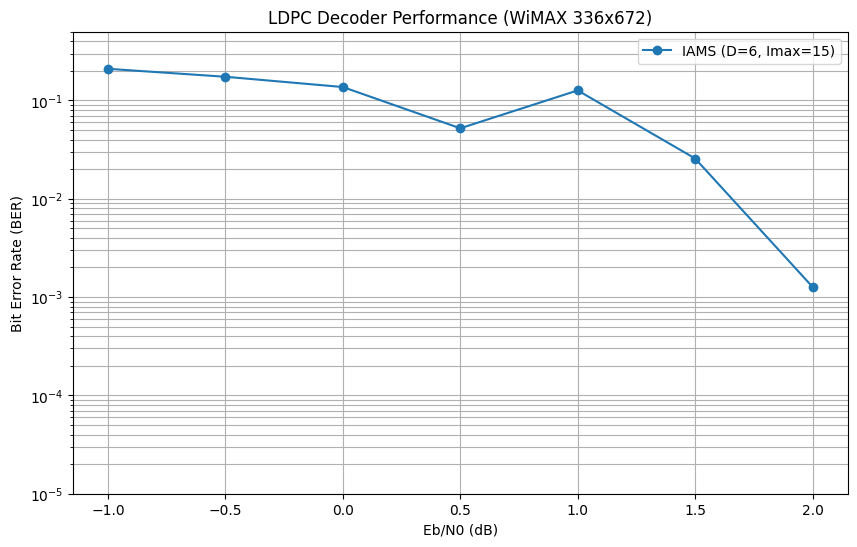

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# ==============================================================================
# Part 1: LDPC Decoder Class implementing the IAMS Algorithm
# ==============================================================================

class LDPC_Decoder:
    """
    This class implements the IAMS (Improved Adapted Min-Sum) LDPC decoder.
    It's initialized using a standard .alist file for the parity-check matrix H.
    """
    def __init__(self, alist_file, max_iter, D_threshold):
        self.max_iter = max_iter
        self.D_threshold = D_threshold
        self._parse_alist(alist_file)

    def _parse_alist(self, file_path):
        """ Parses the .alist file to build the decoder's structure. """
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # First line: matrix dimensions
        self.num_vn, self.num_cn = map(int, lines[0].strip().split())

        # Second line: max degrees (we'll calculate our own)
        # Third line: column degrees
        self.vn_degrees = np.array(list(map(int, lines[2].strip().split())))
        
        # Fourth line: row degrees
        self.cn_degrees = np.array(list(map(int, lines[3].strip().split())))

        # Subsequent lines: non-zero entries for each column (VN)
        vn_lines = lines[4 : 4 + self.num_vn]
        # Final lines: non-zero entries for each row (CN)
        cn_lines = lines[4 + self.num_vn : 4 + self.num_vn + self.num_cn]

        # Create connection lookups (more useful than a sparse matrix for message passing)
        self.cn_connections = [np.array([int(i)-1 for i in line.strip().split()]) for line in cn_lines]
        self.vn_connections = [np.array([int(i)-1 for i in line.strip().split()]) for line in vn_lines]

        print(f"Loaded H matrix of size {self.num_cn}x{self.num_vn} from {file_path}")
        print(f"Code Rate (approx): {1 - self.num_cn/self.num_vn:.2f}")


    def decode(self, llr_vector):
        """
        Decodes a received LLR vector using the layered IAMS algorithm.
        """
        # --- Initialization (Step 1 from the paper) --- 
        app_llrs = np.copy(llr_vector)
        # We store CTV messages in a matrix for simplicity. A real implementation would be sparse.
        ctv_messages = np.zeros((self.num_cn, self.num_vn))

        for iteration in range(self.max_iter):
            # --- Iterative Process (Layered Schedule) --- [cite: 128]
            # We process one Check Node (row) at a time, which is the simplest form of layered schedule.
            for m in range(self.num_cn):
                connected_vns_indices = self.cn_connections[m]

                # --- Step 1: VN Update (calculating VTC messages) --- [cite: 130]
                # VTC message beta_n,m = APP_n - CTV_m,n (from previous iteration)
                # (Equation 2 in the paper) 
                vtc_messages = app_llrs[connected_vns_indices] - ctv_messages[m, connected_vns_indices]

                # --- Step 2: CN Update (The core of IAMS) --- [cite: 133]
                new_ctv_for_layer = np.zeros(len(connected_vns_indices))
                
                for i, n_target in enumerate(connected_vns_indices):
                    # Get extrinsic messages (all VTCs except the one for the target VN)
                    extrinsic_vtc = np.delete(vtc_messages, i)
                    
                    if len(extrinsic_vtc) == 0: continue

                    # Calculate sign product
                    sign_product = np.prod(np.sign(extrinsic_vtc))
                    
                    # --- Find min1 and min2 --- [cite: 170]
                    abs_extrinsic = np.abs(extrinsic_vtc)
                    min1 = np.min(abs_extrinsic)
                    
                    # Temporarily replace min1 with infinity to find min2
                    temp = np.where(abs_extrinsic == min1, np.inf, abs_extrinsic)
                    min2 = np.min(temp)

                    # --- Apply Column Degree Adaptation & Modified CN-Update ---
                    # (Algorithm 1, lines 7-12 in the paper) [cite: 307-312]
                    # Note: We apply this to all checks, not just core checks as in 5G.
                    if self.vn_degrees[n_target] >= self.D_threshold:
                        # Use OMS update (Equation 5) [cite: 146]
                        magnitude = max(min1 - 1, 0)
                    else:
                        # Use Proposed Modified CN-Update (Equation 10) 
                        delta = min2 - min1
                        if delta == 0 and min1 > 0: # Case from Property and Eq. (10) [cite: 188]
                            magnitude = max(min1 - 1, 0)
                        else: # All other cases in Eq. (10) for extrinsic VNs
                            magnitude = min1
                    
                    new_ctv_for_layer[i] = sign_product * magnitude

                # --- Step 3: APP Update (Corrected Logic)---
                # (Equation 7 in the paper) 
                # Update the APP values for the VNs in the current layer.
                # APP_new = VTC + CTV_new
                app_llrs[connected_vns_indices] = vtc_messages + new_ctv_for_layer

                # Store the new CTV messages for the next iteration.
                ctv_messages[m, connected_vns_indices] = new_ctv_for_layer

            # --- Hard Decision and Syndrome Check --- [cite: 158]
            decoded_codeword = (app_llrs < 0).astype(int)
            # To check the syndrome, we need the H matrix in a 0/1 format
            H_matrix_for_check = np.zeros((self.num_cn, self.num_vn), dtype=int)
            for m in range(self.num_cn):
                H_matrix_for_check[m, self.cn_connections[m]] = 1
            
            syndrome = (H_matrix_for_check @ decoded_codeword) % 2
            if not np.any(syndrome):
                # print(f"Converged at iteration {iteration+1}")
                return decoded_codeword, iteration + 1
        
        # print("Max iterations reached.")
        return decoded_codeword, self.max_iter


# ==============================================================================
# Part 2: Simulation Framework (Channel and Plotting)
# ==============================================================================

def run_simulation():
    """ Main function to run the BER simulation and plot results. """
    # --- Simulation Parameters ---
    alist_file = 'wimax_1_2_672.alist'  # Using the WiMAX matrix as requested
    max_iter = 15                       # As used in Fig. 4 of the paper [cite: 351]
    D_threshold = 6                     # An example value, as used for one code in the paper [cite: 277]
    
    ebn0_db_range = np.arange(-1.0, 2.5, 0.5)
    # Set simulation limits for a balance of speed and accuracy
    min_error_count = 50  # Target at least 50 bit errors for statistical significance
    max_frames = 20000    # But don't run more than 20,000 frames per point
    
    # Load decoder
    decoder = LDPC_Decoder(alist_file, max_iter, D_threshold)
    code_rate = 1 - decoder.num_cn / decoder.num_vn
    
    ber_results = []
    
    print("\n--- Starting BER Simulation ---")
    start_time = time.time()
    
    for eb_n0_db in ebn0_db_range:
        # Convert Eb/N0 from dB to linear scale
        eb_n0_linear = 10**(eb_n0_db / 10)
        # Calculate noise variance (sigma^2)
        # Eb/N0 = (Signal Power / Noise Power) * (Bandwidth / Data Rate)
        # For BPSK, Signal Power = 1. Code Rate = k/n.
        noise_variance = decoder.num_vn / (2 * code_rate * decoder.num_vn * eb_n0_linear)
        sigma = np.sqrt(noise_variance)

        total_bit_errors = 0
        total_bits_transmitted = 0

        print(f"Running for Eb/N0 = {eb_n0_db:.1f} dB...")

        for frame_num in range(1, max_frames + 1):
            # --- Transmitter ---
            # (Your existing code for this part is fine)
            message = np.zeros(decoder.num_vn, dtype=int)
            transmitted_signal = 1 - 2 * message

            # --- AWGN Channel ---
            # (Your existing code for this part is fine)
            noise = np.random.normal(0, sigma, transmitted_signal.shape)
            received_signal = transmitted_signal + noise

            # --- Receiver (LLR Calculation) ---
            # (Your existing code for this part is fine)
            initial_llrs = 2 * received_signal / noise_variance
            
            # --- Decoder ---
            # (Your existing code for this part is fine)
            decoded_codeword, iters = decoder.decode(initial_llrs)

            # --- Error Counting ---
            # (Your existing code for this part is fine)
            bit_errors = np.sum(message != decoded_codeword)
            total_bit_errors += bit_errors
            total_bits_transmitted += decoder.num_vn
            
            # --- New Stopping Condition ---
            # Stop if we have enough errors OR we've hit the max frame limit
            if total_bit_errors >= min_error_count:
                print(f"  (Found {total_bit_errors} errors in {frame_num} frames, stopping early)")
                break
        
        # After the loop, check if we ran out of frames
        if frame_num == max_frames:
             print(f"  (Max frames reached, found {total_bit_errors} errors)")

        ber = total_bit_errors / total_bits_transmitted
        ber_results.append(ber)
        print(f"-> BER = {ber:.2e} ({total_bit_errors} errors)")

    end_time = time.time()
    print(f"\nSimulation finished in {end_time - start_time:.2f} seconds.")

    # --- Plotting Results ---
    plt.figure(figsize=(10, 6))
    plt.semilogy(ebn0_db_range, ber_results, 'o-', label=f'IAMS (D={D_threshold}, Imax={max_iter})')
    plt.grid(True, which='both')
    plt.xlabel('Eb/N0 (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.title(f'LDPC Decoder Performance (WiMAX {decoder.num_cn}x{decoder.num_vn})')
    plt.ylim(1e-5, 0.5)
    plt.legend()
    plt.show()


if __name__ == '__main__':
    run_simulation()